In [65]:
!pip3 install scikit-learn
!pip3 install pandas 
!pip3 install tabulate
!pip3 install seaborn

import pandas as pd
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import math

import numpy as np

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -------- ------------------------------ 61.4/294.9 kB 656.4 kB/s eta 0:00:01
   ---------------------- ----------------- 163.8/294.9 kB 1.2 MB/s eta 0:00:01
   --------------------------------- ------ 245.8/294.9 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.4 MB/s eta 0:00:00


Load Dataset


In [67]:
dataset = pd.read_csv('./dataset/loan-10k.lrn.csv')
test_data = pd.read_csv('./dataset/loan-10k.tes.csv')

# Delete whitespace in column names
dataset.columns = dataset.columns.str.strip()
test_data.columns = test_data.columns.str.strip()

Histogram

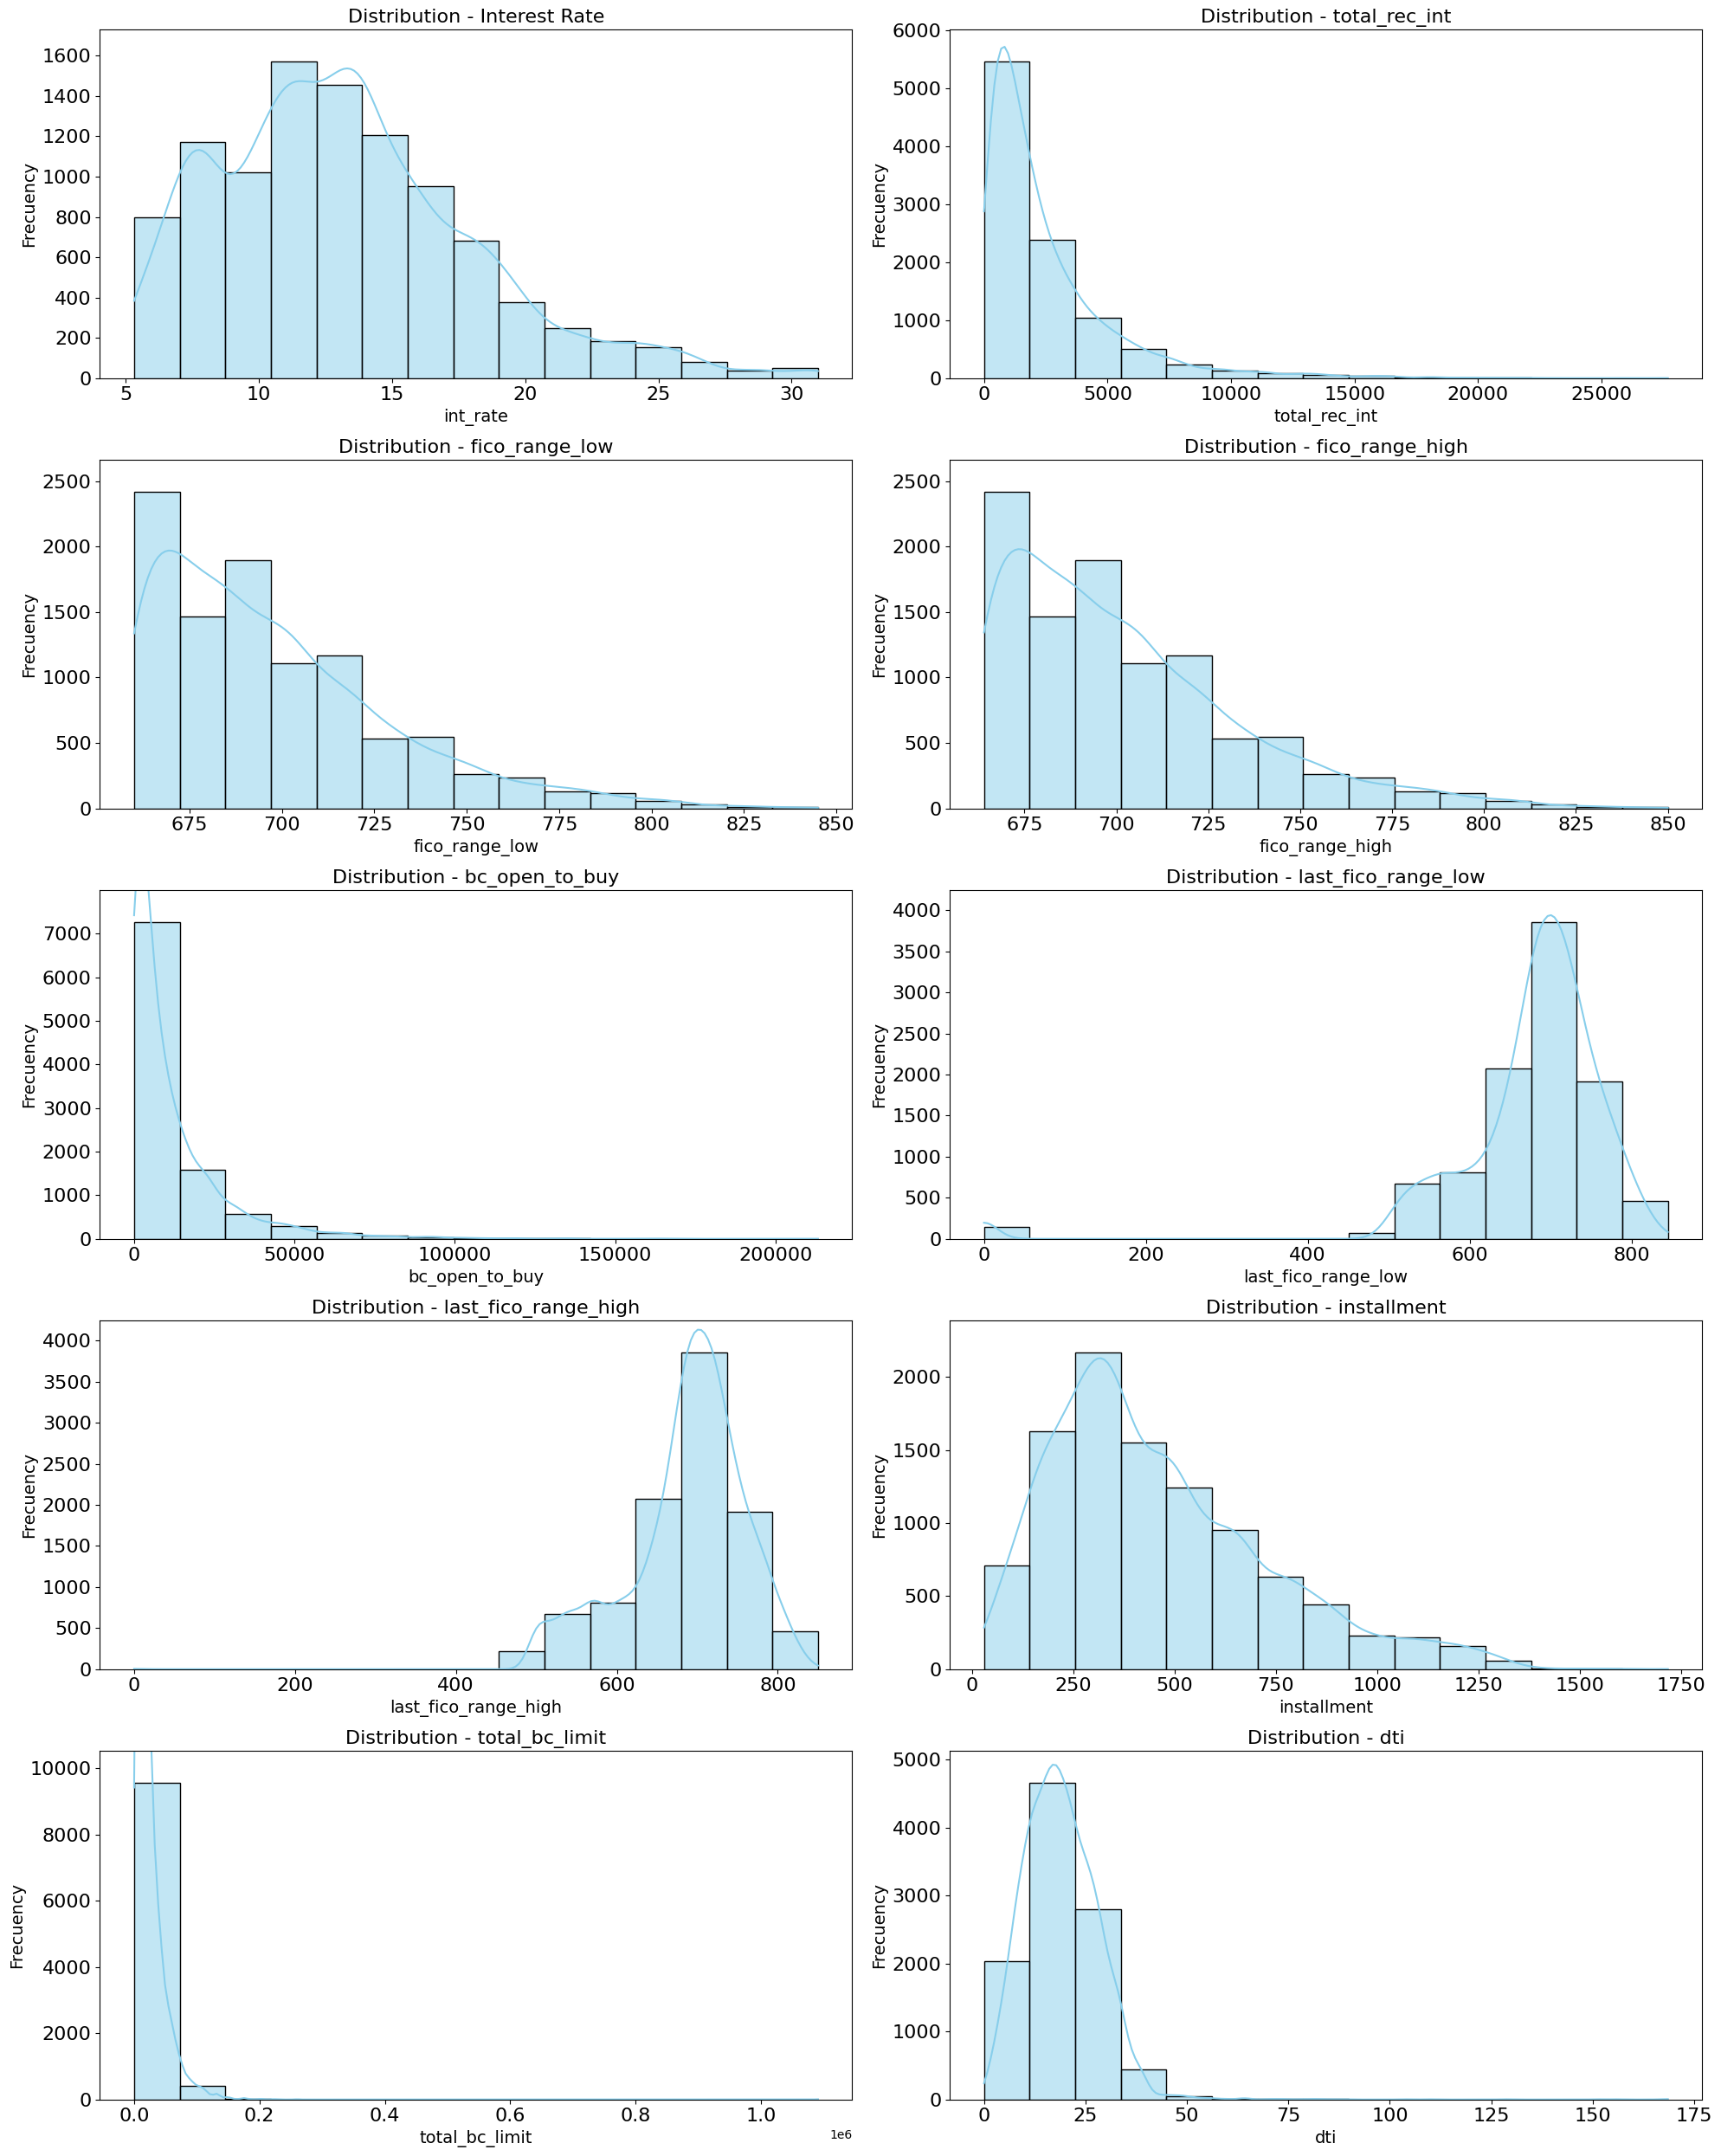

In [69]:
columns_to_plot = {
    'int_rate': 'Interest Rate',
    'total_rec_int': 'total_rec_int',
    'fico_range_low': 'fico_range_low',
    'fico_range_high': 'fico_range_high',
    'bc_open_to_buy': 'bc_open_to_buy',
    'last_fico_range_low': 'last_fico_range_low',
    'last_fico_range_high': 'last_fico_range_high',
    'installment': 'installment',
    'total_bc_limit': 'total_bc_limit',
    'dti': 'dti',
}

charts_per_row = 2
total_columns = len(columns_to_plot)
rows = math.ceil(total_columns / charts_per_row)

fig, axs = plt.subplots(rows, charts_per_row, figsize=(20, rows * 5))

axs = axs.ravel()

for i, column in enumerate(columns_to_plot):
    if pd.api.types.is_numeric_dtype(dataset[column]):
        sns.histplot(dataset[column], kde=True, ax=axs[i], color='skyblue', edgecolor='black', bins=15)
        max_count = max(np.histogram(dataset[column].dropna(), bins=15)[0])
        axs[i].set_ylim(top=max_count * 1.1) 
    else:
        sns.countplot(data=dataset, x=column, ax=axs[i], color='skyblue', edgecolor='black')
        axs[i].tick_params(axis='x', rotation=20)
    
    axs[i].tick_params(axis='y', labelsize=16)
    axs[i].tick_params(axis='x', labelsize=16)
    axs[i].set_title(f'Distribution - {columns_to_plot[column]}', fontsize=16)
    axs[i].set_xlabel(column, fontsize=14)
    axs[i].set_ylabel('Frecuency', fontsize=14)

plt.tight_layout()
plt.show()
fig.savefig('loan_histogram.png', dpi=fig.dpi)

Preprocessing Dataset

In [49]:
lable_encode = LabelEncoder()
def booleanMapper(x):
    if x == 'N':
        return 0
    else:
        return 1

dataset = pd.get_dummies(dataset, dtype=int, columns = ['term', 'emp_length', 'home_ownership', 'verification_status', 'loan_status', 
                                             'purpose', 'addr_state', 'initial_list_status', 'disbursement_method'])

dataset['grade'] = lable_encode.fit_transform(dataset['grade'])
dataset['debt_settlement_flag'] = dataset['debt_settlement_flag'].apply(booleanMapper)

Preprocessing test set

In [50]:
test_data['term'] = lable_encode.fit_transform(test_data['term'])
test_data['emp_length'] = lable_encode.fit_transform(test_data['emp_length'])
test_data['home_ownership'] = lable_encode.fit_transform(test_data['home_ownership'])
test_data['verification_status'] = lable_encode.fit_transform(test_data['verification_status'])
test_data['loan_status'] = lable_encode.fit_transform(test_data['loan_status'])
test_data['purpose'] = lable_encode.fit_transform(test_data['purpose'])
test_data['addr_state'] = lable_encode.fit_transform(test_data['addr_state'])
test_data['initial_list_status'] = lable_encode.fit_transform(test_data['initial_list_status'])
test_data['application_type'] = lable_encode.fit_transform(test_data['application_type'])
test_data['disbursement_method'] = lable_encode.fit_transform(test_data['disbursement_method'])
test_data['debt_settlement_flag'] = test_data['debt_settlement_flag'].apply(booleanMapper)

test_data = test_data.drop('pymnt_plan', axis=1) #only 5/10000 have this on true
test_data = test_data.drop('hardship_flag', axis=1) #only 6/10000 have this on true
test_data = test_data.drop('policy_code', axis=1) #same value for every entry
test_data = test_data.drop('num_tl_120dpd_2m', axis=1) #very low importance <0.0001
test_data = test_data.drop('num_tl_30dpd', axis=1) #very low importance <0.0001
test_data = test_data.drop('acc_now_delinq', axis=1) #very low importance <0.0001
test_data = test_data.drop('delinq_amnt', axis=1) #very low importance <0.0001
test_data = test_data.drop('chargeoff_within_12_mths', axis=1) #very low importance <0.0001
test_data = test_data.drop('collections_12_mths_ex_med', axis=1) #very low importance <0.0001
test_data = test_data.drop('debt_settlement_flag', axis=1) #very low importance <0.0001
test_data = test_data.drop('tax_liens', axis=1) #very low importance <0.0001
test_data = test_data.drop('application_type', axis=1) #very low importance <0.0001
test_data = test_data.drop('num_tl_90g_dpd_24m', axis=1) #very low importance <0.0001

KNN


In [51]:
def knnModel(training_set, training_validation, testing_set, testing_validation, scaling, neighbors = 0, weight = 'uniform'):
    k_values = list(range(1, 20))
    a_scores = []
    k = neighbors

    if k == 0:
        for n in k_values:
            knn_model = KNeighborsClassifier(n_neighbors=n, weights=weight)
            knn_model.fit(training_set, training_validation)
            Y_predicted = knn_model.predict(testing_set)
            
            score = accuracy_score(testing_validation, Y_predicted)
            a_scores.append(score)

        k = k_values[np.argmax(a_scores)]

    knn_model = KNeighborsClassifier(n_neighbors=k, weights=weight)
    start_holdout = time.process_time()
    knn_model.fit(training_set, training_validation)
    Y_predicted = knn_model.predict(testing_set)
    end_holdout = time.process_time()

    accuracy = accuracy_score(testing_validation, Y_predicted)
    f1 = f1_score(testing_validation, Y_predicted, average='weighted')
    report = classification_report(testing_validation, Y_predicted, output_dict=True)
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']

    start_cross = time.process_time()
    scores = cross_val_score(
            knn_model, 
            np.concatenate((training_set, testing_set), axis=0), 
            np.concatenate((training_validation, testing_validation), axis=0), 
            cv=5, 
            scoring='accuracy'
        )
    avg_cross_accuracy = scores.mean()
    end_cross = time.process_time()

    # Return metrics
    return {
        "scaling": str(scaling),
        "k": k,
        "weights": weight,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "avg_cross": avg_cross_accuracy,
        "runtime_holdout": end_holdout - start_holdout,
        "runtime_cross": end_cross - start_cross
    }


Neural Network

In [52]:
def neuralNetworkModel(training_set, training_validation, testing_set, testing_validation, scaling):
    hidden_layers = [(5, 3), (20, 10, 5)]
    activations = ['relu', 'identity', 'logistic', 'tanh']
    solvers = ['adam', 'lbfgs', 'sgd']

    results = []
    for hidden_layer in hidden_layers:
        for activation in activations:
            for solver in solvers:
        
                neural_network_model = MLPClassifier(hidden_layer, max_iter=100, activation=activation, solver=solver, random_state=42)

                start_holdout = time.process_time()
                neural_network_model.fit(training_set, training_validation)
                Y_predicted = neural_network_model.predict(testing_set)
                end_holdout = time.process_time()
                accuracy = accuracy_score(testing_validation, Y_predicted)
                f1 = f1_score(testing_validation, Y_predicted, average='weighted')
                report = classification_report(testing_validation, Y_predicted, output_dict=True)
                precision = report['macro avg']['precision']
                recall = report['macro avg']['recall']

                start_cross = time.process_time()
                scores = cross_val_score(
                        neural_network_model, 
                        np.concatenate((training_set, testing_set), axis=0), 
                        np.concatenate((training_validation, testing_validation), axis=0), 
                        cv=5, 
                        scoring='accuracy'
                    )
                avg_cross_accuracy = scores.mean()
                end_cross = time.process_time()

                results.append({
                    "scaling": str(scaling),
                    "hidden_layers": hidden_layer,
                    "activation": activation,
                    "solver": solver,
                    "accuracy": accuracy,
                    "precision": precision,
                    "recall": recall,
                    "f1_score": f1,
                    "avg_cross": avg_cross_accuracy,
                    "runtime_holdout": end_holdout - start_holdout,
                    "runtime_cross": end_cross - start_cross
                })

    results_df = pd.DataFrame(results)
    markdown_table = results_df.to_markdown(index=False)
    print(markdown_table)

Random Forest

In [53]:
def randomForestModel(training_set, training_validation, testing_set, testing_validation, scaling = True):
    # Define the configurations
    leaf_nodes = [5, 100, 5000]
    max_depth = [5, 20, 1000]
    max_features = [5, 20]

    # Initialize a list to store the results
    results = []

    # Loop over all configurations
    for l in leaf_nodes:
        for d in max_depth:
            for f in max_features:
                # Initialize the MLP model
                # Initializing the Random Forest model
                random_forest_model = RandomForestClassifier(
                                        max_leaf_nodes=l,
                                        max_depth=d,
                                        max_features=f,
                                        random_state=42
                                    )

                # Train and evaluate the model
                start_holdout = time.process_time()
                random_forest_model.fit(training_set, training_validation)
                Y_predicted = random_forest_model.predict(testing_set)
                end_holdout = time.process_time()

                accuracy = accuracy_score(testing_validation, Y_predicted)
                f1 = f1_score(testing_validation, Y_predicted, average='weighted')
                report = classification_report(testing_validation, Y_predicted, output_dict=True)
                precision = report['macro avg']['precision']
                recall = report['macro avg']['recall']
                start_cross = time.process_time()
                scores = cross_val_score(
                    random_forest_model, 
                    np.concatenate((training_set, testing_set), axis=0), 
                    np.concatenate((training_validation, testing_validation), axis=0), 
                    cv=5, 
                    scoring='accuracy'
                    )
                end_cross = time.process_time()
                avg_cross_accuracy = scores.mean()
                # Append the results to the list
                results.append({
                    "scaling": str(scaling),
                    "leaf_nodes": l,
                    "max_depth": d,
                    "max_features": f,
                    "Accuracy": accuracy,
                    "Precision": precision,
                    "Recall": recall,
                    "F1": f1,
                    "avg_cross": avg_cross_accuracy,
                    "runtime_holdout": end_holdout - start_holdout,
                    "runtime_cross": end_cross - start_cross
                })

    # Convert the results to a DataFrame
    results_df = pd.DataFrame(results)

    # Convert the DataFrame to a Markdown table
    markdown_table = results_df.to_markdown(index=False)

    # Print the Markdown table
    print(markdown_table)

Dropping unnecessary attributes, scaling and splitting up the set

In [54]:
dataset_attributes = dataset.drop('grade', axis=1)
dataset_attributes = dataset_attributes.drop(columns= ['pymnt_plan', 'hardship_flag', 'policy_code', 'num_tl_120dpd_2m', 'num_tl_30dpd',
                                                       'acc_now_delinq', 'delinq_amnt', 'chargeoff_within_12_mths','collections_12_mths_ex_med', 
                                                       'debt_settlement_flag', 'tax_liens', 'application_type', 'num_tl_90g_dpd_24m'], axis=1)
dataset_class = dataset['grade']

scaler = StandardScaler()
training_set = dataset_attributes.head(9000)
testing_set = dataset_attributes.tail(1000)
training_set = scaler.fit_transform(training_set)
testing_set = scaler.fit_transform(testing_set)
testing_validation = dataset_class.tail(1000)
training_validation = dataset_class.head(9000)


Dropping certain amount of features using random forest classifier

In [66]:
model = RandomForestClassifier(random_state=42)

# Fit the model to the data
model.fit(dataset_attributes, dataset_class)

# Get the most important features
most_important_attributes = pd.DataFrame(
                            model.feature_importances_,
                            index = dataset_attributes.columns,
                            columns=['importance']
                        ).sort_values('importance', ascending=False)

dropped_collums_01 = most_important_attributes[most_important_attributes['importance'] < 0.01].index.tolist()
dropped_collums_015 = most_important_attributes[most_important_attributes['importance'] < 0.015].index.tolist()
dropped_collums_02 = most_important_attributes[most_important_attributes['importance'] < 0.02].index.tolist()
dataset_attributes_dropped_01 = dataset_attributes.drop(axis=1, columns = dropped_collums_01)
training_set_dropped_01 = dataset_attributes_dropped_01.head(9000)
testing_set_dropped_01 = dataset_attributes_dropped_01.tail(1000)
training_set_dropped_01 = scaler.fit_transform(training_set_dropped_01)
testing_set_dropped_01 = scaler.fit_transform(testing_set_dropped_01)

dataset_attributes_dropped_015 = dataset_attributes.drop(axis=1, columns = dropped_collums_015)
training_set_dropped_015 = dataset_attributes_dropped_015.head(9000)
testing_set_dropped_015 = dataset_attributes_dropped_015.tail(1000)
training_set_dropped_015 = scaler.fit_transform(training_set_dropped_015)
testing_set_dropped_015 = scaler.fit_transform(testing_set_dropped_015)

dataset_attributes_dropped_02 = dataset_attributes.drop(axis=1, columns = dropped_collums_02)
training_set_dropped_02 = dataset_attributes_dropped_02.head(9000)
testing_set_dropped_02 = dataset_attributes_dropped_02.tail(1000)
training_set_dropped_02 = scaler.fit_transform(training_set_dropped_02)
testing_set_dropped_02 = scaler.fit_transform(testing_set_dropped_02)


KNN Tests

In [62]:
results = []
results.append(knnModel(training_set, training_validation, testing_set, testing_validation, True)) #optimal + scaling + all features
results.append(knnModel(training_set, training_validation, testing_set, testing_validation, True, weight='distance')) #optimal + scaling + all features
results.append(knnModel(training_set, training_validation, testing_set, testing_validation, True, neighbors=5)) #5 + scaling + all features
results.append(knnModel(training_set, training_validation, testing_set, testing_validation, True, neighbors=10)) #10 + scaling + all features
results.append(knnModel(dataset_attributes.head(9000), training_validation, dataset_attributes.tail(1000), testing_validation, False)) #optimal + all features
results.append(knnModel(dataset_attributes.head(9000), training_validation, dataset_attributes.tail(1000), testing_validation, False, weight='distance')) #optimal + all features
results.append(knnModel(dataset_attributes.head(9000), training_validation, dataset_attributes.tail(1000), testing_validation, False, neighbors=5)) #5 + all features
results.append(knnModel(dataset_attributes.head(9000), training_validation, dataset_attributes.tail(1000), testing_validation, False, neighbors=10)) #10 + all features
results.append(knnModel(training_set_dropped_01, training_validation, testing_set_dropped_01, testing_validation, True)) #optimal + scaling + 0.01
results.append(knnModel(training_set_dropped_01, training_validation, testing_set_dropped_01, testing_validation, True, weight='distance')) #optimal + scaling + 0.01
results.append(knnModel(training_set_dropped_01, training_validation, testing_set_dropped_01, testing_validation, True, neighbors=5)) #5 + scaling + 0.01
results.append(knnModel(training_set_dropped_01, training_validation, testing_set_dropped_01, testing_validation, True, neighbors=10)) #10 + scaling + 0.01
results.append(knnModel(training_set_dropped_015, training_validation, testing_set_dropped_015, testing_validation, True)) #optimal + scaling + 0.015
results.append(knnModel(training_set_dropped_015, training_validation, testing_set_dropped_015, testing_validation, True, weight='distance')) #optimal + scaling + 0.015
results.append(knnModel(training_set_dropped_015, training_validation, testing_set_dropped_015, testing_validation, True, neighbors=5)) #5 + scaling + 0.015
results.append(knnModel(training_set_dropped_015, training_validation, testing_set_dropped_015, testing_validation, True, neighbors=10)) #10 + scaling + 0.015
results.append(knnModel(training_set_dropped_02, training_validation, testing_set_dropped_02, testing_validation, True)) #optimal + scaling + 0.02
results.append(knnModel(training_set_dropped_02, training_validation, testing_set_dropped_02, testing_validation, True, weight='distance')) #optimal + scaling + 0.02
results.append(knnModel(training_set_dropped_02, training_validation, testing_set_dropped_02, testing_validation, True, neighbors=5)) #5 + scaling + 0.02
results.append(knnModel(training_set_dropped_02, training_validation, testing_set_dropped_02, testing_validation, True, neighbors=10)) #10 + scaling + 0.02

print(results)

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

[{'scaling': 'True', 'k': 13, 'weights': 'uniform', 'accuracy': 0.395, 'precision': 0.2761394877396545, 'recall': 0.2404589805880178, 'f1_score': 0.3627763177971271, 'avg_cross': 0.38780000000000003, 'runtime_holdout': 0.6875, 'runtime_cross': 1.484375}, {'scaling': 'True', 'k': 15, 'weights': 'distance', 'accuracy': 0.398, 'precision': 0.23473583055970373, 'recall': 0.23598934641323752, 'f1_score': 0.3693701345739451, 'avg_cross': 0.3996, 'runtime_holdout': 0.21875, 'runtime_cross': 1.609375}, {'scaling': 'True', 'k': 5, 'weights': 'uniform', 'accuracy': 0.391, 'precision': 0.41889898638991196, 'recall': 0.2564104996536315, 'f1_score': 0.36427078757023074, 'avg_cross': 0.3719, 'runtime_holdout': 0.625, 'runtime_cross': 1.234375}, {'scaling': 'True', 'k': 10, 'weights': 'uniform', 'accuracy': 0.377, 'precision': 0.2522021023497153, 'recall': 0.2293929440679741, 'f1_score': 0.34684167818445655, 'avg_cross': 0.38320000000000004, 'runtime_holdout': 0.65625, 'runtime_cross': 1.515625}, {'s

Neural Network tests

In [63]:
neuralNetworkModel(training_set, training_validation, testing_set, testing_validation, True) #scaling + all features
#neuralNetworkModel(dataset_attributes.head(9000), training_validation, dataset_attributes.tail(1000), testing_validation, False) #all features
neuralNetworkModel(training_set_dropped_01, training_validation, testing_set_dropped_01, testing_validation, True) #scaling + 0.01
neuralNetworkModel(training_set_dropped_015, training_validation, testing_set_dropped_015, testing_validation, True) #scaling + 0.015
#neuralNetworkModel(training_set_dropped_02, training_validation, testing_set_dropped_02, testing_validation, True) #scaling + 0.02

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in 

| scaling   | hidden_layers   | activation   | solver   |   accuracy |   precision |   recall |   f1_score |   avg_cross |   runtime_holdout |   runtime_cross |
|:----------|:----------------|:-------------|:---------|-----------:|------------:|---------:|-----------:|------------:|------------------:|----------------:|
| True      | (5, 3)          | relu         | adam     |      0.85  |   0.65622   | 0.640923 |   0.844089 |      0.8571 |          2.03125  |         8.90625 |
| True      | (5, 3)          | relu         | lbfgs    |      0.854 |   0.677431  | 0.624291 |   0.846797 |      0.8557 |          0.359375 |         1.67188 |
| True      | (5, 3)          | relu         | sgd      |      0.756 |   0.461092  | 0.471049 |   0.722932 |      0.788  |          1.8125   |         8.15625 |
| True      | (5, 3)          | identity     | adam     |      0.84  |   0.645743  | 0.625731 |   0.833605 |      0.8541 |          1.95312  |         8.3125  |
| True      | (5, 3)          | id

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Random Forest Tests

In [58]:
randomForestModel(training_set, training_validation, testing_set, testing_validation)
randomForestModel(dataset_attributes.head(9000), training_validation, dataset_attributes.tail(1000), testing_validation, scaling=False)
randomForestModel(training_set_dropped_01, training_validation, testing_set_dropped_01, testing_validation)
randomForestModel(training_set_dropped_015, training_validation, testing_set_dropped_015, testing_validation)
randomForestModel(training_set_dropped_02, training_validation, testing_set_dropped_02, testing_validation)

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

| scaling   |   leaf_nodes |   max_depth |   max_features |   Accuracy |   Precision |   Recall |       F1 |   avg_cross |   runtime_holdout |   runtime_cross |
|:----------|-------------:|------------:|---------------:|-----------:|------------:|---------:|---------:|------------:|------------------:|----------------:|
| True      |            5 |           5 |              5 |      0.55  |    0.295686 | 0.290747 | 0.446309 |      0.5808 |          0.40625  |         2.03125 |
| True      |            5 |           5 |             20 |      0.667 |    0.326    | 0.376337 | 0.582381 |      0.6762 |          1.07812  |         5.23438 |
| True      |            5 |          20 |              5 |      0.55  |    0.295686 | 0.290747 | 0.446309 |      0.5808 |          0.40625  |         2.03125 |
| True      |            5 |          20 |             20 |      0.667 |    0.326    | 0.376337 | 0.582381 |      0.6762 |          1        |         5.14062 |
| True      |            5 |      

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

| scaling   |   leaf_nodes |   max_depth |   max_features |   Accuracy |   Precision |   Recall |       F1 |   avg_cross |   runtime_holdout |   runtime_cross |
|:----------|-------------:|------------:|---------------:|-----------:|------------:|---------:|---------:|------------:|------------------:|----------------:|
| True      |            5 |           5 |              5 |      0.558 |    0.298398 | 0.294195 | 0.45151  |      0.5826 |          0.40625  |         1.95312 |
| True      |            5 |           5 |             20 |      0.677 |    0.33177  | 0.380805 | 0.591063 |      0.6708 |          1.04688  |         4.84375 |
| True      |            5 |          20 |              5 |      0.558 |    0.298398 | 0.294195 | 0.45151  |      0.5826 |          0.421875 |         2.01562 |
| True      |            5 |          20 |             20 |      0.677 |    0.33177  | 0.380805 | 0.591063 |      0.6708 |          1.03125  |         4.71875 |
| True      |            5 |      

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

| scaling   |   leaf_nodes |   max_depth |   max_features |   Accuracy |   Precision |   Recall |       F1 |   avg_cross |   runtime_holdout |   runtime_cross |
|:----------|-------------:|------------:|---------------:|-----------:|------------:|---------:|---------:|------------:|------------------:|----------------:|
| True      |            5 |           5 |              5 |      0.679 |    0.331397 | 0.386095 | 0.594587 |      0.6854 |          0.875    |         4.09375 |
| True      |            5 |           5 |             20 |      0.846 |    0.56958  | 0.572512 | 0.832699 |      0.8611 |          3        |        13.9531  |
| True      |            5 |          20 |              5 |      0.679 |    0.331397 | 0.386095 | 0.594587 |      0.6854 |          0.890625 |         4.07812 |
| True      |            5 |          20 |             20 |      0.846 |    0.56958  | 0.572512 | 0.832699 |      0.8611 |          3        |        14       |
| True      |            5 |      

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

| scaling   |   leaf_nodes |   max_depth |   max_features |   Accuracy |   Precision |   Recall |       F1 |   avg_cross |   runtime_holdout |   runtime_cross |
|:----------|-------------:|------------:|---------------:|-----------:|------------:|---------:|---------:|------------:|------------------:|----------------:|
| True      |            5 |           5 |              5 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.65625  |         3.09375 |
| True      |            5 |           5 |             20 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.828125 |         4.01562 |
| True      |            5 |          20 |              5 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.6875   |         3.125   |
| True      |            5 |          20 |             20 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.890625 |         4.04688 |
| True      |            5 |      

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classific

| scaling   |   leaf_nodes |   max_depth |   max_features |   Accuracy |   Precision |   Recall |       F1 |   avg_cross |   runtime_holdout |   runtime_cross |
|:----------|-------------:|------------:|---------------:|-----------:|------------:|---------:|---------:|------------:|------------------:|----------------:|
| True      |            5 |           5 |              5 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.53125  |         2.26562 |
| True      |            5 |           5 |             20 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.515625 |         2.21875 |
| True      |            5 |          20 |              5 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.515625 |         2.20312 |
| True      |            5 |          20 |             20 |      0.847 |    0.571499 | 0.576645 | 0.834671 |      0.8657 |          0.453125 |         2.23438 |
| True      |            5 |      